# Сборный проект 2

## Описание проекта

Данные находятся в трёх файлах:

- gold_recovery_train_new.csv — обучающая выборка;

- gold_recovery_test_new.csv — тестовая выборка;

- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

### Инструкция по выполнению проекта

1. **Подготовьте данные**

    1.1. Откройте файлы и изучите их.

Путь к файлам:

/datasets/gold_recovery_train_new.csv. https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv

/datasets/gold_recovery_test_new.csv. https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv

/datasets/gold_recovery_full_new.csv. https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv

    1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
    
    1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
    
    1.4. Проведите предобработку данных.
    
2. **Проанализируйте данные**

    2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
    
    2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
    
    2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

3. **Постройте модель**

    3.1. Напишите функцию для вычисления итоговой sMAPE.
    
    3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.
    
Вам пригодятся формулы метрик качества:

<img src="images/2022-12-12_12-03-49.png" width=40%>

## 1. Загрузка данных

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState
from scipy import stats as st

import seaborn as sns

try:
    import sweetviz as sv
except:
    !pip install sweetviz
    import sweetviz as sv
    

import os
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
#from progressbar.bar import ProgressBar
from tqdm import tqdm


In [2]:
# Читаем данные из файлов
try:
    data_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')  
    
# Смотрим на данные
display(data_full, data_train, data_test)


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [3]:
# Напишем функцию, которая покажет общую информацию о датафрейме


def show_dataframe_info(data, name):
    rows, columns = data.shape
    print(f"\033[1m{name}\033[0m")
    print(f'В датафрейме количество стоблцов равно: ', columns)
    print(f'В датафрейме количество строк равно:', rows)
    display(data.head(5))
    display(data.describe())
    data.info()
    print("")

In [4]:
#  Изучим датафреймы
show_dataframe_info(data_train, 'Тренировочные данные')
show_dataframe_info(data_test, 'Тестовые данные')
show_dataframe_info(data_full, 'Сырые данные')

Тренировочные данные
В датафрейме количество стоблцов равно:  87
В датафрейме количество строк равно: 14149


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [5]:
# Проведем дополнительно EDA-анализ с помощью библиотеки sweetviz и построим три отчета: 

try:
    if os.path.exists('./FULL DATA REPORT.html'):
        print("Данные уже загружены")
        print("Отчеты лежат в текущем каталоге: FULL DATA REPORT.html, TRAIN DATA REPORT, TEST DATA REPORT")
except:
    report = sv.analyze([data_full, "FULL DATA REPORT"])
    report.show_html('FULL DATA REPORT.html')
    report2 = sv.analyze([data_train, "TRAIN DATA REPORT"])
    report2.show_html('TRAIN DATA REPORT.html')
    report3 = sv.analyze([data_test, "TEST DATA REPORT"])
    report3.show_html('TEST DATA REPORT.html')
    print("Отчеты лежат в текущем каталоге: FULL DATA REPORT.html, TRAIN DATA REPORT, TEST DATA REPORT")

### 1.2. Проверка правильности рассчета эффективности обогащения. Вычислеине её на обучающей выборке для признака rougher.output.recovery. Вычисление MAE между нашими расчётами и значением признака. Выводы.

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

1.4. Проведите предобработку данных.

In [6]:
# Рассчитаем эффективность обогащения на обучающей выборке
# C — доля золота в концентрате после флотации/очистки rougher.output.concentrate_au;
# F — доля золота в сырье/концентрате до флотации/очистки rougher.input.feed_au;
# T — доля золота в отвальных хвостах после флотации/очистки rougher.output.tail_au.

recovery = (data_train['rougher.output.concentrate_au'] * (data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au'])) * 100/  (data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']))
print(recovery.describe())

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64


In [7]:
# Посчитаем MAE признака rougher.output.recovery в наших рассчетах и тренировочной выборке

mae = mean_absolute_error(data_train['rougher.output.recovery'], recovery)
print('MAE =', mae)

MAE = 1.1131451184435918e-14


**Значение MAE очень маленькое. Это говорит о том, что рассчеты произведены верно**

In [8]:
# Сравним фреймы тренировочной и тестовой выборок и выведим на экран признаки, отсутствующие в тестовой выборке.
list1 = data_train.columns.to_list()
list2 = data_test.columns.to_list() 
#not_include_test_cols = [x for x in list1 + list2 if x not in list1 or x not in list2] 
not_include_test_cols = [x for x in list1 if x not in list2] 
print("Этих столбцов нету в тестовой выборке\n")
print("Количество: ", len(not_include_test_cols))
data_train[not_include_test_cols].info()

Этих столбцов нету в тестовой выборке

Количество:  34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au 

**В тестовой выборке отсутсвуют фичи, которые вычисляются по ходу процесса. Они будут известны на этапах производства. Все столбцы, которые есть в тренировочной, но ету в тестовой выборке имеют тип float**

In [9]:
# Проведем предобработку данных
# Посмотрим сколько всего пропусков, %

display(pd.DataFrame(round(data_train.isna().mean()*100, ).sort_values(ascending=False)).style.background_gradient('coolwarm'))

,0
secondary_cleaner.output.tail_sol,11.000000
rougher.input.floatbank11_xanthate,3.000000
rougher.state.floatbank10_e_air,3.000000
primary_cleaner.output.concentrate_sol,2.000000
secondary_cleaner.state.floatbank2_a_air,2.000000
final.output.tail_pb,1.000000
final.output.concentrate_sol,1.000000
primary_cleaner.input.xanthate,1.000000
primary_cleaner.output.concentrate_pb,1.000000
rougher.input.feed_pb,1.000000


In [10]:
# Добавим целевые показатели в датасет data_test из датасета data_full, в качестве ключа использовав date

print("Было строк и солбцов:", data_test.shape)

data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

print("Стало строк и столбцов:", data_test.shape)

Было строк и солбцов: (5290, 53)
Стало строк и столбцов: (5290, 55)


In [11]:
print(data_test['rougher.output.recovery'].isna().sum())
print(data_test['final.output.recovery'].isna().sum())

0
0


**В таргетах пустых значений нет**

In [12]:
# Заполним пустые значения в тестовом и тренировочном сетах соседними значениями, так как по условию они похоже
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
# Пропусков больше нет

In [13]:
# подсчёт явных дубликатов
print("Явных дубликатов в тренировочном сете:", data_train.duplicated().sum())
print("Явных дубликатов в тестовом сете:", data_test.duplicated().sum())
print("Явных дубликатов в полном сете:", data_full.duplicated().sum())

Явных дубликатов в тренировочном сете: 0
Явных дубликатов в тестовом сете: 0
Явных дубликатов в полном сете: 0


**Вывод: Обработали пропуски в тестовом и тренировочном датафреймах.Больше всего пропусков было в тренировочном сете secondary_cleaner.output.tail_sol - 11%. По условию проэкта вс значения соседних дат схожие, поэтому применили метод заполнения соседними значениями ffill. В тестовый сет добавили колонки таргетов из полного сета. Merge сдлали по дате. Дату удалили из выборок, так как это лишний признак для решения задачи. В конце провели проверку на явные дубли - их нет.**

## 2. Проанализируйте данные

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

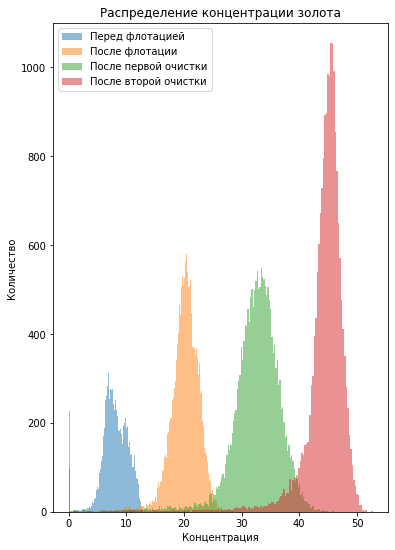

In [14]:
# Посмотрим на концентрацию  золота на всех этапах
plt.figure(figsize=[6,9])

plt.hist(data_full['rougher.input.feed_au'], bins=200, label = 'Перед флотацией', alpha=0.5)
plt.hist(data_full['rougher.output.concentrate_au'], bins=200, label = 'После флотации', alpha=0.5)
plt.hist(data_full['primary_cleaner.output.concentrate_au'], bins=200, label = 'После первой очистки', alpha=0.5)
plt.hist(data_full['final.output.concentrate_au'], bins=200, label = 'После второй очистки', alpha=0.5)

#plt.xlim([0, 60])
plt.ylim([0, 1100])

plt.xlabel("Концентрация")
plt.ylabel("Количество")

plt.legend(loc='upper left')

plt.title("Распределение концентрации золота")
plt.show()

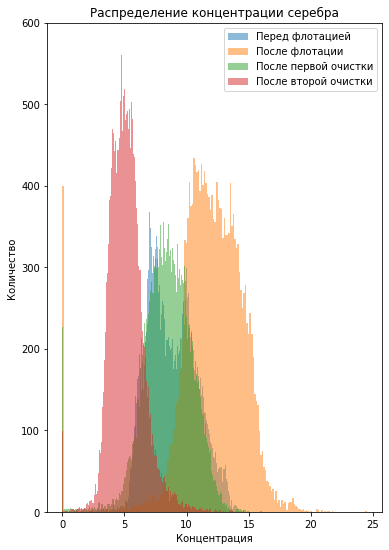

In [15]:
# Посмотрим на концентрацию  серебра на всех этапах
plt.figure(figsize=[6,9])

plt.hist(data_full['rougher.input.feed_ag'], bins=200, label = 'Перед флотацией', alpha=0.5)
plt.hist(data_full['rougher.output.concentrate_ag'], bins=200, label = 'После флотации', alpha=0.5)
plt.hist(data_full['primary_cleaner.output.concentrate_ag'], bins=200, label = 'После первой очистки', alpha=0.5)
plt.hist(data_full['final.output.concentrate_ag'], bins=200, label = 'После второй очистки', alpha=0.5)


plt.ylim([0, 600])

plt.xlabel("Концентрация")
plt.ylabel("Количество")

plt.legend(loc='upper right')

plt.title("Распределение концентрации серебра")
plt.show()

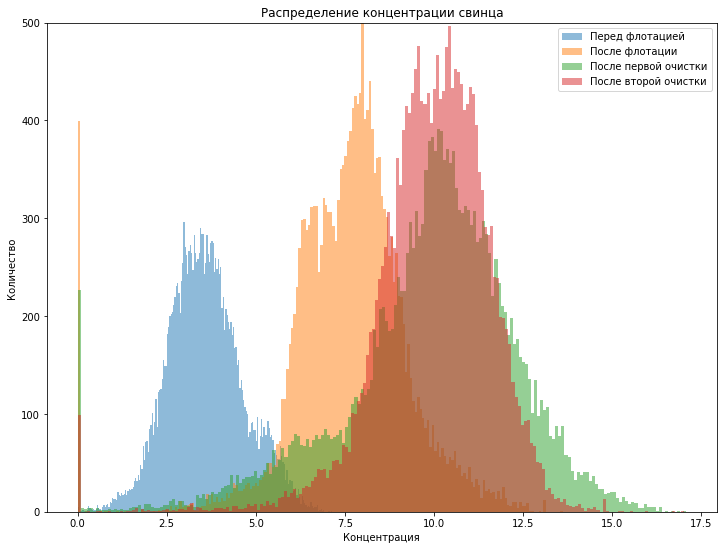

In [16]:
# Посмотрим на концентрацию  свинца на всех этапах
plt.figure(figsize=[12,9])

plt.hist(data_full['rougher.input.feed_pb'], bins=200, label = 'Перед флотацией', alpha=0.5)
plt.hist(data_full['rougher.output.concentrate_pb'], bins=200, label = 'После флотации', alpha=0.5)
plt.hist(data_full['primary_cleaner.output.concentrate_pb'], bins=200, label = 'После первой очистки', alpha=0.5)
plt.hist(data_full['final.output.concentrate_pb'], bins=200, label = 'После второй очистки', alpha=0.5)

#plt.xlim([0, 20])
plt.ylim([0, 500])

plt.xlabel("Концентрация")
plt.ylabel("Количество")

plt.legend(loc='upper right')

plt.title("Распределение концентрации свинца")
plt.show()

**Вывод: Как видно по графикам, концентрация золота минимальна перед флотацией, но на каждом этапе стремительно растет.  Серебро, наоборот, падает. Свица после этапа флотации концентрация выросла, но далее, после воторй очистки, значения сконцентрировались ближе к среднему. Так же заметно, что присутствует много нудевых значений, по всей видимости они являются выбросами**

### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

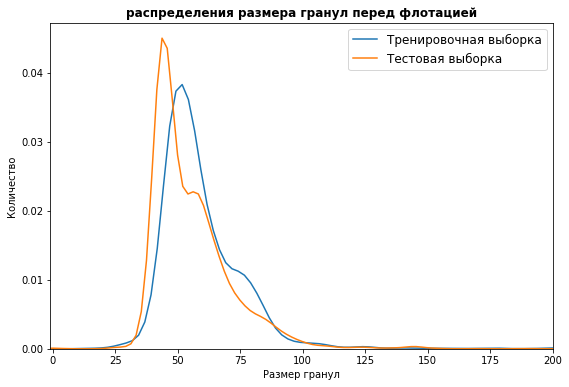

In [17]:
plt.figure(figsize=[9,6])
fig = sns.kdeplot(data_train['rougher.input.feed_size'], 
                   label = 'Тренировочная выборка')
fig = sns.kdeplot(data_test['rougher.input.feed_size'], 
                   label = 'Тестовая выборка')
plt.xlim(-1, 200)
fig.legend(loc='upper right', fontsize='large')
fig.set_title('распределения размера гранул перед флотацией', fontweight = 'bold')
plt.xlabel('Размер гранул')
plt.ylabel('Количество')
plt.show()

**Графики в выборка подобны. Видно, что размер гранул в тренироваочной выборке немного больше, чем в тестовой, это может повлиять  нмаодели, но некритично**

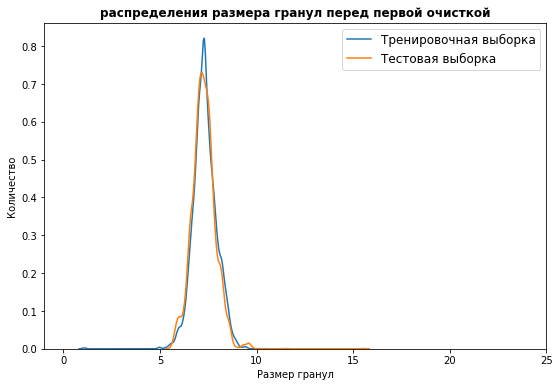

In [18]:
plt.figure(figsize=[9,6])
fig = sns.kdeplot(data_train['primary_cleaner.input.feed_size'], 
                   label = 'Тренировочная выборка')
fig = sns.kdeplot(data_test['primary_cleaner.input.feed_size'], 
                   label = 'Тестовая выборка')
plt.xlim(-1, 25)
fig.legend(loc='upper right', fontsize='large')
fig.set_title('распределения размера гранул перед первой очисткой', fontweight = 'bold')
plt.xlabel('Размер гранул')
plt.ylabel('Количество')
plt.show()

**Видно, что после флотрации размер гранул сильно уменьшился, почти на порядок. Но распределение остается подобным. Тестовая выборка репрезентативна**

### 2.3 Исследуем суммарную концентрацию веществ на всех стадиях производства

In [19]:
final_output_concentrate_au_ag_pb_train = (data_train['final.output.concentrate_au'] + 
                                      data_train['final.output.concentrate_ag'] + 
                                      data_train['final.output.concentrate_pb'] +
                                      data_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_au_ag_pb_sol_train = (data_train['primary_cleaner.output.concentrate_au'] + 
                                                data_train['primary_cleaner.output.concentrate_ag'] + 
                                                data_train['primary_cleaner.output.concentrate_pb'] +
                                                data_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_au_ag_pb_sol_train = (data_train['rougher.output.concentrate_au'] + 
                                        data_train['rougher.output.concentrate_ag'] + 
                                        data_train['rougher.output.concentrate_pb'] +
                                        data_train['rougher.output.concentrate_sol'])
rougher_input_concentrate_au_ag_pb_sol_train = (data_train['rougher.input.feed_au'] + 
                                        data_train['rougher.input.feed_ag'] + 
                                        data_train['rougher.input.feed_pb'] +
                                        data_train['rougher.input.feed_sol'])

concentrate_au_ag_pb_train =  {'Суммарная концентрация в сырье':rougher_input_concentrate_au_ag_pb_sol_train, 'Суммарная концентрация после флотации':rougher_output_concentrate_au_ag_pb_sol_train, 'Суммарная концентрация в черновом концентрате':primary_cleaner_output_concentrate_au_ag_pb_sol_train, 'Суммарная концентрация в финальном концентрате':final_output_concentrate_au_ag_pb_train}


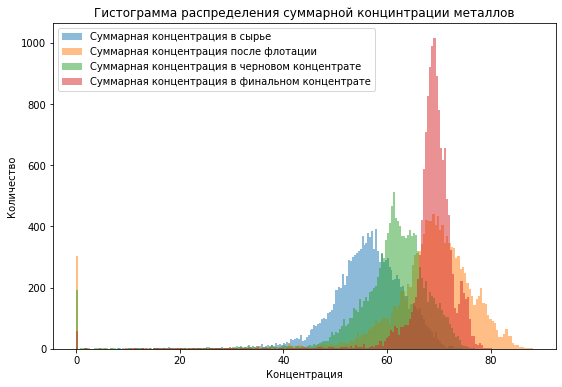

In [20]:
plt.figure(figsize=[9,6])
plt.title("Гистограмма распределения суммарной концинтрации металлов")
plt.xlabel("Концентрация")
plt.ylabel("Количество")
for i, value in concentrate_au_ag_pb_train.items():
    plt.hist(value, bins=200, label=i, alpha=0.5)
    plt.legend(loc='upper left', fontsize='medium')


**Много нулевых значений. Удалим их**

In [21]:
data_train = data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_au'] == 0].index)
data_train[data_train['primary_cleaner.output.concentrate_au'] == 0].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


**Вывод: Исследование данных показало, что присутствуют выбросы, которые мы успешно удалили. Размер гранул на этапе флотации сильно уменьшается. Концентрация золота и свинца на каждом этапе производства увеличивается.**

## 3. Построение модели

<img src="https://downloader.disk.yandex.ru/preview/0105a1905857f0ee030364a63a5bc66d8e56ce23d021133ac041c824b6b3cca0/639fa3c6/qrGVlQOA7m1jYbNeIrsXiIEPmbFEy4ps-oDFmAGWVPJ2XR2xuerDn1TqSrBLOziUAhdlRgSXGbK9wJgctpESfQ%3D%3D?uid=0&filename=2022-12-18_22-34-17.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048" width=60%>

### 3.1 Функции для вычисления sMAPE и итоговой sMAPE

In [22]:
# Функция для вычисления sMAPE
def smape(real, predict):
    return 100/len(real) * np.sum(2 * np.abs(real - predict) / (np.abs(real) + np.abs(predict)))
# Создаем скорер
smape_scoring = make_scorer(smape, greater_is_better=False)

In [23]:
# Функция для вычисления иноговой sMAPE

def final_smape(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

In [24]:
print(data_test.shape)
data_train.shape

(5290, 55)


(14075, 87)

In [25]:
# Оставим в train лишь те фичи, которые есть в test

not_include_test_cols.remove("final.output.recovery")
not_include_test_cols.remove("rougher.output.recovery")

how_test_cols = set(data_train.columns) - set(not_include_test_cols) 

data_train = data_train.drop(not_include_test_cols, axis=1)

print(data_train.shape)
print(data_test.shape)

#Удалим их тестовой и тренеровочной выборок дату, она не нужна
data_test = data_test.drop("date", axis=1)
data_train = data_train.drop("date", axis=1)

# Отберем признаки для этапа rougher из тренировочной выборки
cols = pd.Series(data_train.columns).sort_values(ascending=True).reset_index(drop=True) # Получаем все столбцы по алфавиту с индексами
rougher_features = cols[13:36] # отберем признаки этапа rougher
rougher_features

(14075, 55)
(5290, 55)


13                 rougher.input.feed_ag
14                 rougher.input.feed_au
15                 rougher.input.feed_pb
16               rougher.input.feed_rate
17               rougher.input.feed_size
18                rougher.input.feed_sol
19     rougher.input.floatbank10_sulfate
20    rougher.input.floatbank10_xanthate
21     rougher.input.floatbank11_sulfate
22    rougher.input.floatbank11_xanthate
23               rougher.output.recovery
24       rougher.state.floatbank10_a_air
25     rougher.state.floatbank10_a_level
26       rougher.state.floatbank10_b_air
27     rougher.state.floatbank10_b_level
28       rougher.state.floatbank10_c_air
29     rougher.state.floatbank10_c_level
30       rougher.state.floatbank10_d_air
31     rougher.state.floatbank10_d_level
32       rougher.state.floatbank10_e_air
33     rougher.state.floatbank10_e_level
34       rougher.state.floatbank10_f_air
35     rougher.state.floatbank10_f_level
dtype: object

In [26]:
# Определим таргеты и фичи
rougher_train_target = data_train['rougher.output.recovery']
final_train_target = data_train['final.output.recovery']

rougher_test_target = data_test['rougher.output.recovery']
final_test_target = data_test['final.output.recovery']

features_train = data_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
features_test = data_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)

### 3.2 Оценка качества моделей

**Определим Baseline**

In [27]:
# Для дальшейшей проверки модели на адекватность, определим baseline. Стратегию выберем mean
rougher_dummy = DummyRegressor(strategy = 'mean').fit(features_train, rougher_train_target)

#выберим стратегию расчета по среднему и обучим модель на обучающей выборке
final_dummy = DummyRegressor(strategy = 'mean').fit(features_train, final_train_target)

rougher_predict_dummy = rougher_dummy.predict(features_test)

# Вычислим предсказания на тестовой выборке
final_predict_dummy = final_dummy.predict(features_test)

In [28]:
rougher_smape_test = smape(rougher_test_target, rougher_predict_dummy)#рассчитаем smape для предсказаний rougher
final_smape_test = smape(final_test_target, final_predict_dummy)
result_smape = final_smape(rougher_smape_test, final_smape_test)#расчитаем итоговое smape по функции
print('Итоговый sMAPE на тестовых данных для модели Dummy:', result_smape)

Итоговый sMAPE на тестовых данных для модели Dummy: 10.292328921967524


**Линейная регрессия**

In [29]:
model_logreg = LinearRegression()

# Для этапа rougher
smape_rougher = cross_val_score(model_logreg, features_train, rougher_train_target,
                    cv = 5, scoring = smape_scoring, n_jobs=-1, verbose=10)
mean_smape_rougher = smape_rougher.mean()

# Для этапа final
smape_final = cross_val_score(model_logreg, features_train, final_train_target,
                    cv = 5, scoring = smape_scoring, n_jobs=-1, verbose=10)
mean_smape_final = smape_final.mean()
#print(smape_final)

result_smape = final_smape(mean_smape_rougher, mean_smape_final)

print("Итоговый sMAPE:", result_smape)

[CV] START .....................................................................
[CV] END .............................. score: (test=-14.998) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.630) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-17.925) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.650) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.125) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.474) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.023) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.953) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.341) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.141) total time=   0.3s
Итоговый sMAPE: -12.35639403986757


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


**Дерево решений**

In [30]:
%%time
best_result = 100
best_depth = 0
for depth in range(1, 10, 1):
    model_tree= DecisionTreeRegressor(max_depth=depth, random_state=42)
    smape_rougher = cross_val_score(model_tree,
                              features_train,
                              rougher_train_target,
                              scoring=smape_scoring,
                              cv=5, n_jobs=-1, verbose=10)
    mean_smape_rougher = smape_rougher.mean()

    smape_final = cross_val_score(model_tree, 
                                  features_train,
                                  final_train_target,
                                  scoring=smape_scoring,
                                  cv=5, n_jobs=-1, verbose=10)
    mean_smape_final = smape_final.mean()
    result_smape = final_smape(mean_smape_rougher, mean_smape_final)
    if result_smape < best_result:
        best_result = result_smape
        best_depth = depth

print("Итоговый sMAPE:", best_result)
print("Лучшая глубина:", best_depth)

[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.655) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.578) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.980) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-18.692) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.313) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.966) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.209) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.454) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.638) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.676) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.221) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.307) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.819) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-16.227) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.537) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.007) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.145) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.764) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.207) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.477) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.634) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.142) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.701) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-21.272) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.572) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.242) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.721) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.954) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.837) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.367) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.758) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.239) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.256) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.965) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.584) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.399) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.492) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.546) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.987) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.747) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.263) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.746) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.193) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-20.448) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.625) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.632) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.603) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.682) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.864) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.320) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.751) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.670) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.306) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-20.370) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.059) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.826) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.596) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.790) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.125) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.441) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-25.701) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.956) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.636) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-21.438) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.109) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.645) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-24.271) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.149) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.671) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.894) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-25.395) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.776) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-16.214) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-17.550) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.284) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.350) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-16.253) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.035) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.007) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.484) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-25.113) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.320) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-16.416) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.973) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.271) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.683) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.513) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.741) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.793) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-19.374) total time=   0.4s
Итоговый sMAPE: -14.970301493095088
Лучшая глубина: 9
CPU times: user 23.8 s, sys: 109 ms, total: 23.9 s
Wall time: 24.2 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


**Модель случайного леса**

In [31]:
# %%time
# best_result = 100
# count = 0
# for n_est in tqdm(range(10, 51, 10)):
# #for n_est in tqdm(range(1,3)):
#     for depth in range(1, 11):
#         model_forest = RandomForestRegressor(random_state = 42, 
#                                       n_estimators = n_est, max_depth = depth)
#         smape_rougher = cross_val_score(model_forest, features_train, rougher_train_target, 
#                             cv = 5, scoring = smape_scoring)
#         mean_smape_rougher = smape_rougher.mean()
        
#         smape_final = cross_val_score(model_forest, features_train, final_train_target, 
#                             cv = 5, scoring = smape_scoring)
#         mean_smape_final = smape_final.mean()
        
#         result_smape = final_smape(mean_smape_rougher, mean_smape_final)
#         if mean_smape_rougher < best_result:
#             best_result = mean_smape_rougher 
#             best_model = model_forest
#             best_est = n_est
#         count += 1

# print("Лучшее итоговое sMAPE:", best_result)
# print("Лучшая глубина:", best_depth)
# print("Лучшее количество деревьев:", best_est)

**Закоментированный выше код выполняется очень долго. Попробуем решить задачу через RandomizedSearchCV**

In [32]:
%%time
param = {'n_estimators': range(10, 31, 10), 'max_depth': range(1,15)}
model_RF = RandomForestRegressor(random_state = 42)

#rougher
grid_rf_rougher = RandomizedSearchCV(model_RF,param,scoring = smape_scoring, cv=5, n_iter=1, n_jobs=-1, verbose=10)
grid_rf_rougher.fit(features_train, rougher_train_target)

#final
grid_rf_final = RandomizedSearchCV(model_RF,param,scoring = smape_scoring, cv=5, n_iter=1, n_jobs=-1, verbose=10)
grid_rf_final.fit(features_train, final_train_target)

result_smape = final_smape(grid_rf_rougher.best_score_, grid_rf_final.best_score_)

print('Лучший sMAPE rougher:', grid_rf_rougher.best_score_, 'при', grid_rf_rougher.best_params_)
print('Лучший sMAPE final:', grid_rf_final.best_score_, 'при', grid_rf_final.best_params_)
print('Итоговый sMAPE:', result_smape)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=14, n_estimators=20...............................
[CV 1/5; 1/1] END .............max_depth=14, n_estimators=20; total time=   7.6s
[CV 2/5; 1/1] START max_depth=14, n_estimators=20...............................
[CV 2/5; 1/1] END .............max_depth=14, n_estimators=20; total time=   7.6s
[CV 3/5; 1/1] START max_depth=14, n_estimators=20...............................
[CV 3/5; 1/1] END .............max_depth=14, n_estimators=20; total time=   7.4s
[CV 4/5; 1/1] START max_depth=14, n_estimators=20...............................
[CV 4/5; 1/1] END .............max_depth=14, n_estimators=20; total time=   7.8s
[CV 5/5; 1/1] START max_depth=14, n_estimators=20...............................
[CV 5/5; 1/1] END .............max_depth=14, n_estimators=20; total time=   7.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=9, n_estimators=10........................

**Вывод:Наилучшим образом себя показала модель решающего дерева. Ее и будем тестировать.**

### Обучение модели с лучшим sMAPE

In [33]:
# Обучаем лучшую модель на тренировочных данных
grid_rf_rougher = grid_rf_rougher.fit(features_train, rougher_train_target)
grid_rf_final = grid_rf_final.fit(features_train, final_train_target)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=5, n_estimators=20................................
[CV 1/5; 1/1] END ..............max_depth=5, n_estimators=20; total time=   3.2s
[CV 2/5; 1/1] START max_depth=5, n_estimators=20................................
[CV 2/5; 1/1] END ..............max_depth=5, n_estimators=20; total time=   3.2s
[CV 3/5; 1/1] START max_depth=5, n_estimators=20................................
[CV 3/5; 1/1] END ..............max_depth=5, n_estimators=20; total time=   3.2s
[CV 4/5; 1/1] START max_depth=5, n_estimators=20................................
[CV 4/5; 1/1] END ..............max_depth=5, n_estimators=20; total time=   3.2s
[CV 5/5; 1/1] START max_depth=5, n_estimators=20................................
[CV 5/5; 1/1] END ..............max_depth=5, n_estimators=20; total time=   3.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=3, n_estimators=20........................

In [34]:
# Считаем sMAPE на тестовых данных для лучшей модели

#предскажем на тестовой выборке rougher и final
rougher_predict = grid_rf_rougher.predict(features_test)
final_predict = grid_rf_final.predict(features_test)

# Считаем sMAPE
smape_rougher = smape(rougher_test_target, rougher_predict)
smape_final = smape(final_test_target, final_predict)

# Считаем итоговый sMAPE
result_smape = final_smape(smape_rougher, smape_final)

# Выводим результаты
print('sMAPE rougher на тестовых данных::', smape_rougher)
print('sMAPE final на тестовых данных::', smape_final)
print("Итоговый sMAPE на тестовых данных:", result_smape)

sMAPE rougher на тестовых данных:: 10.32623704470177
sMAPE final на тестовых данных:: 9.45787567977809
Итоговый sMAPE на тестовых данных: 9.67496602100901


**Общий вывод: В ходе решения задачи регрессии были проанализированы 3 датасета, проведена предобработка данных и протестированы модели линейной регресси, решающего дерева и случайного леса. Так же была построена константная модель для проверки на адекватность. Лучше других показала себя модель случайного леса по итоговой метрике sMAPE. На тестовых данных работа модели показала результат 9.66 Dummy-модель показала результат 10.29, следовательно, модель адекватна и ее можно внедрять в производство для его оптимизации.**